In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# 构建股票投资组合，数据获取。
从沪深300指数中任意选取5只股票构建投资组合，总资金100万。
资金分配权重为初始时刻在指数中的权重。
回测区间：2020/5/1 - 2021/5/1

In [22]:
#2020/5/1 - 2021/5/1 从Tushare获取数据
import tushare as ts
pro = ts.pro_api()
hs300_weight = ts.get_hs300s()
hs300_weight.head()

,date,code,name,weight
0,2021-04-30,600000,浦发银行,0.61
1,2021-04-30,600004,白云机场,0.08
2,2021-04-30,600009,上海机场,0.25
3,2021-04-30,600010,包钢股份,0.17
4,2021-04-30,600011,华能国际,0.10


In [23]:
hs300_price = pd.read_csv('hs300_price.csv',names = ['date','ts_code','close','open','high','low','pre_close','change','pct_chg','vol','amount'],header = 0)
hs300_price.head()

,date,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,20180801,000300.SH,"3,447.39","3,530.03","3,543.61","3,446.78","3,517.66",-70.27,-2.00,"90,348,617.00","107,477,214.87"
1,20180802,000300.SH,"3,370.96","3,434.35","3,434.35","3,322.10","3,447.39",-76.43,-2.22,"101,308,727.00","122,401,283.62"
2,20180803,000300.SH,"3,315.28","3,366.66","3,381.34","3,315.20","3,370.96",-55.67,-1.65,"70,796,910.00","91,395,987.15"
3,20180806,000300.SH,"3,273.27","3,312.82","3,344.25","3,257.69","3,315.28",-42.01,-1.27,"77,975,083.00","97,517,991.02"
4,20180807,000300.SH,"3,368.87","3,284.98","3,368.96","3,263.50","3,273.27",95.60,2.92,"91,783,916.00","107,512,223.95"


In [24]:
import random
hs300_list = [x for x in range(0,300)]
random.shuffle(hs300_list)
hs300_choice5 = hs300_list[0:5]

In [25]:
hs300_choice5

[181, 205, 116, 106, 231]

In [26]:
hs300_choice5 = hs300_weight.loc[hs300_choice5]
hs300_choice5

,date,code,name,weight
181,2021-04-30,688009,中国通号,0.08
205,2021-04-30,000708,中信特钢,0.14
116,2021-04-30,601288,农业银行,0.48
106,2021-04-30,601169,北京银行,0.37
231,2021-04-30,002120,韵达股份,0.10


In [27]:
hs300_choice5.reset_index(inplace = True)

[227,69,158,138,271]

In [28]:
hs300_choice5['invest_weight'] = hs300_choice5['weight']/sum( hs300_choice5['weight']) 
hs300_choice5

,index,date,code,name,weight,invest_weight
0,181,2021-04-30,688009,中国通号,0.08,0.07
1,205,2021-04-30,000708,中信特钢,0.14,0.12
2,116,2021-04-30,601288,农业银行,0.48,0.41
3,106,2021-04-30,601169,北京银行,0.37,0.32
4,231,2021-04-30,002120,韵达股份,0.10,0.09


In [29]:
for i in range(len(hs300_choice5['code'])):
    if str(hs300_choice5.loc[i,'code'])[0] != '6':
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SZ'
    else:
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SH'
hs300_choice5

,index,date,code,name,weight,invest_weight
0,181,2021-04-30,688009.SH,中国通号,0.08,0.07
1,205,2021-04-30,000708.SZ,中信特钢,0.14,0.12
2,116,2021-04-30,601288.SH,农业银行,0.48,0.41
3,106,2021-04-30,601169.SH,北京银行,0.37,0.32
4,231,2021-04-30,002120.SZ,韵达股份,0.10,0.09


In [30]:
time_on = '20200501'
time_off = '20210501'

从tushare 抓取 五只股票历史行情并保存成文件的代码

In [31]:
df_ldkg = pro.daily(ts_code=str(hs300_choice5['code'][0]), start_date=time_on, end_date=time_off)
df_zssk = pro.daily(ts_code=str(hs300_choice5['code'][1]), start_date=time_on, end_date=time_off)
df_ztdq = pro.daily(ts_code=str(hs300_choice5['code'][2]), start_date=time_on, end_date=time_off)
df_zgtb = pro.daily(ts_code=str(hs300_choice5['code'][3]), start_date=time_on, end_date=time_off)
df_xbzq = pro.daily(ts_code=str(hs300_choice5['code'][4]), start_date=time_on, end_date=time_off)

2. 构建建仓汇总表（dataframe）。
假设以2018/8/1开盘价买入股票，生成包含下列信息的dataframe
股票名称，权重，资金分配，买入价格，买入股数，买入佣金，剩余现金

买入手续费为成交额的0.025%，最少5元。


In [32]:
#invest_vol 初始投资额
#invest_weight 投资比重
#初始投资80万  20万留作剩余现金
hs300_choice5['invest_vol'] = hs300_choice5['invest_weight'] * 1000000*0.8
hs300_choice5.head()

,index,date,code,name,weight,invest_weight,invest_vol
0,181,2021-04-30,688009.SH,中国通号,0.08,0.07,"54,700.85"
1,205,2021-04-30,000708.SZ,中信特钢,0.14,0.12,"95,726.50"
2,116,2021-04-30,601288.SH,农业银行,0.48,0.41,"328,205.13"
3,106,2021-04-30,601169.SH,北京银行,0.37,0.32,"252,991.45"
4,231,2021-04-30,002120.SZ,韵达股份,0.10,0.09,"68,376.07"


In [33]:
#将数据按照日期进行排序
df_ldkg = df_ldkg.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zssk = df_zssk.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_ztdq = df_ztdq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zgtb = df_zgtb.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_xbzq = df_xbzq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_ldkg.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,688009.SH,20200506,6.10,6.44,6.08,6.43,6.16,0.27,4.38,"551,470.43","348,747.74"
1,688009.SH,20200507,6.40,6.44,6.28,6.29,6.43,-0.14,-2.18,"339,211.15","214,818.07"
2,688009.SH,20200508,6.31,6.40,6.30,6.34,6.29,0.05,0.79,"276,801.70","175,406.16"
3,688009.SH,20200511,6.34,6.36,6.27,6.29,6.34,-0.05,-0.79,"195,062.57","123,130.67"
4,688009.SH,20200512,6.30,6.31,6.20,6.25,6.29,-0.04,-0.64,"171,043.73","106,647.04"


In [34]:
#stock_daily——将五只股票的2020年5月6日的 ['ts_code','trade_date','open','close'] [股票代码，交易日期，开盘价，收盘价]拼接在一起
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
daily_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[0],stock_list[1][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
n = 2
while n <5:
    daily_data = pd.concat([daily_data,stock_list[n][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
    n = n + 1
stock_daily = daily_data.T
stock_daily

,ts_code,trade_date,open,close
0,688009.SH,20200506,6.10,6.43
0,000708.SZ,20200506,15.87,15.42
0,601288.SH,20200506,3.42,3.42
0,601169.SH,20200506,4.93,4.94
0,002120.SZ,20200506,29.51,29.30


In [35]:
#hs300_choice5 沪深300的选择的五只股票的基本信息
hs300_choice5 = hs300_choice5.reset_index()#重置索引
hs300_choice5

,level_0,index,date,code,name,weight,invest_weight,invest_vol
0,0,181,2021-04-30,688009.SH,中国通号,0.08,0.07,"54,700.85"
1,1,205,2021-04-30,000708.SZ,中信特钢,0.14,0.12,"95,726.50"
2,2,116,2021-04-30,601288.SH,农业银行,0.48,0.41,"328,205.13"
3,3,106,2021-04-30,601169.SH,北京银行,0.37,0.32,"252,991.45"
4,4,231,2021-04-30,002120.SZ,韵达股份,0.10,0.09,"68,376.07"


In [36]:
hs300_choice5['ts_code'] = hs300_choice5['code']
hs300_choice5.drop('code',axis =1,inplace =True)
hs300_choice5

,level_0,index,date,name,weight,invest_weight,invest_vol,ts_code
0,0,181,2021-04-30,中国通号,0.08,0.07,"54,700.85",688009.SH
1,1,205,2021-04-30,中信特钢,0.14,0.12,"95,726.50",000708.SZ
2,2,116,2021-04-30,农业银行,0.48,0.41,"328,205.13",601288.SH
3,3,106,2021-04-30,北京银行,0.37,0.32,"252,991.45",601169.SH
4,4,231,2021-04-30,韵达股份,0.10,0.09,"68,376.07",002120.SZ


In [37]:
#将stock_daily 与 股票详细信息拼接在一起
stock_daily  = pd.merge(stock_daily,hs300_choice5[['name','invest_weight','invest_vol','ts_code']],on = 'ts_code')
stock_daily

,ts_code,trade_date,open,close,name,invest_weight,invest_vol
0,688009.SH,20200506,6.10,6.43,中国通号,0.07,"54,700.85"
1,000708.SZ,20200506,15.87,15.42,中信特钢,0.12,"95,726.50"
2,601288.SH,20200506,3.42,3.42,农业银行,0.41,"328,205.13"
3,601169.SH,20200506,4.93,4.94,北京银行,0.32,"252,991.45"
4,002120.SZ,20200506,29.51,29.30,韵达股份,0.09,"68,376.07"


In [38]:
stock_daily['trade_cost'] = stock_daily['invest_vol'] * 0.00025#计算交易费用
for i in stock_daily['trade_cost']:
    if i < 5:
        i = 5
stock_daily['price_in'] = stock_daily['open']
stock_daily['stock_num'] = stock_daily['invest_vol'] / stock_daily['price_in']
stock_daily

,ts_code,trade_date,open,close,name,invest_weight,invest_vol,trade_cost,price_in,stock_num
0,688009.SH,20200506,6.10,6.43,中国通号,0.07,"54,700.85",13.68,6.10,"8,967.35"
1,000708.SZ,20200506,15.87,15.42,中信特钢,0.12,"95,726.50",23.93,15.87,"6,031.92"
2,601288.SH,20200506,3.42,3.42,农业银行,0.41,"328,205.13",82.05,3.42,"95,966.41"
3,601169.SH,20200506,4.93,4.94,北京银行,0.32,"252,991.45",63.25,4.93,"51,316.72"
4,002120.SZ,20200506,29.51,29.30,韵达股份,0.09,"68,376.07",17.09,29.51,"2,317.05"


In [39]:
#求2020年5月6日的现金剩余现金 trade_cost交易费用
cash_remain = 1000000 - sum(stock_daily['trade_cost'] ) - sum(stock_daily['invest_vol'])
print('剩余现金为：',cash_remain)

剩余现金为： 199799.99999999988


3. 策略1：初始买入建仓后一直持有。

In [40]:
#final_daily 2021年4月30日的股票详细信息 和 stock_daily 同理
final_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[242],stock_list[1][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
n = 2
while n <5:
    final_data = pd.concat([final_data,stock_list[n][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
    n = n + 1
final_daily = final_data.T
final_daily

,ts_code,trade_date,open,close
242,688009.SH,20210430,5.60,5.61
242,000708.SZ,20210430,26.00,25.88
242,601288.SH,20210430,3.23,3.20
242,601169.SH,20210430,4.79,4.76
242,002120.SZ,20210430,15.05,16.10


In [41]:
stock_daily = pd.merge(stock_daily,final_daily[['ts_code','open']],on = 'ts_code')

In [42]:
stock_daily['price_out'] = stock_daily['open_y']
stock_daily['trade_cost_out'] = stock_daily['price_out']* stock_daily['stock_num']*(0.01 + 0.00025)#股票卖出的交易费用 包含印花税
for i in  stock_daily['trade_cost_out']:
    if i < 0:
        i = 0
stock_daily['harvest_vol'] = stock_daily['price_out']* stock_daily['stock_num']
stock_daily

,ts_code,trade_date,open_x,close,name,invest_weight,invest_vol,trade_cost,price_in,stock_num,open_y,price_out,trade_cost_out,harvest_vol
0,688009.SH,20200506,6.10,6.43,中国通号,0.07,"54,700.85",13.68,6.10,"8,967.35",5.60,5.60,514.73,"50,217.18"
1,000708.SZ,20200506,15.87,15.42,中信特钢,0.12,"95,726.50",23.93,15.87,"6,031.92",26.00,26.00,"1,607.51","156,829.80"
2,601288.SH,20200506,3.42,3.42,农业银行,0.41,"328,205.13",82.05,3.42,"95,966.41",3.23,3.23,"3,177.21","309,971.51"
3,601169.SH,20200506,4.93,4.94,北京银行,0.32,"252,991.45",63.25,4.93,"51,316.72",4.79,4.79,"2,519.52","245,807.11"
4,002120.SZ,20200506,29.51,29.30,韵达股份,0.09,"68,376.07",17.09,29.51,"2,317.05",15.05,15.05,357.43,"34,871.56"


In [43]:
#21年4月30日卖出股票 计算剩余现金
cash_remain = cash_remain -sum(stock_daily['trade_cost_out']) + sum(stock_daily['harvest_vol'])
print('剩余现金为：',cash_remain)

剩余现金为： 989320.7645191082


4. 策略2：长短期均线策略。

4.1 计算长短期均线。（有函数可以调用，见后文代码）
 5日均线，20日均线。分为简单平均及指数移动平均。

### 5日均线

In [44]:
############计算均线
# 简单平均
def smaCal(tsPrice, k):  # 输入价格序列,Series
    Sma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice)):
        Sma[i] = sum(tsPrice[(i - k + 1):(i + 1)]) / k
    Sma.index = tsPrice.index
    return (Sma)

# 加权平均
def wmaCal(tsPrice, weight):  # 输入价格序列,Series
    k = len(weight)
    arrWeight = np.array(weight)
    Wma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice.index)):
        Wma[i] = sum(arrWeight * tsPrice[(i - k + 1):(i + 1)])
    Wma.index = tsPrice.index
    return (Wma)

In [45]:
def _ema(tsprice):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    N = len(tsprice)
    alpha = 2/(N+1)
    data = np.zeros(len(tsprice))
    for i in range(len(data)):
        data[i] = tsprice[i] if i==0 else alpha*tsprice[i]+(1-alpha)*data[i-1]
    return data[-1]
def ewmaCal(tsprice,period):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    data = pd.Series(np.nan ,index = list(range(len(tsprice))))
    for i in range(period-1,len(tsprice)):
        data[i] = _ema(tsprice[i+1-period:i+1])
    data.index = temple
    return data

In [46]:
for i in stock_list:
    i.index = i['trade_date']

In [47]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
df_ldkg_mean5 = df_ldkg[['trade_date','close']]
df_ldkg_mean5.head()

,trade_date,close
trade_date,,
20200506,20200506,6.43
20200507,20200507,6.29
20200508,20200508,6.34
20200511,20200511,6.29
20200512,20200512,6.25


In [48]:
#简单平均
df_ldkg_mean5 = smaCal(df_ldkg_mean5['close'],5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
df_ldkg_mean5.head(15)

,0
trade_date,
20200506,nan
20200507,nan
20200508,nan
20200511,nan
20200512,6.32
20200513,6.28
20200514,6.26
20200515,6.23
20200518,6.21


In [49]:
#加权平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]
weight = [0.10,0.15,0.20,0.25,0.30]#权重列表      
df_ldkg_mean5 = wmaCal(df_ldkg_mean5['close'],weight)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
df_ldkg_mean5.head(15)

,0
trade_date,
20200506,nan
20200507,nan
20200508,nan
20200511,nan
20200512,6.30
20200513,6.27
20200514,6.24
20200515,6.22
20200518,6.20


In [50]:
# 指数移动平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]    
df_ldkg_mean5 = ewmaCal(df_ldkg_mean5['close'],period=5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
df_ldkg_mean5.head(15)

,0
trade_date,
20200506,nan
20200507,nan
20200508,nan
20200511,nan
20200512,6.31
20200513,6.27
20200514,6.24
20200515,6.23
20200518,6.20


* 5日均线(简单平均)  

In [51]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_simple5 = smaCal(df_ldkg['close'],5)
df_zssk_simple5 = smaCal(df_zssk['close'],5)
df_ztdq_simple5 = smaCal(df_ztdq['close'],5)
df_zgtb_simple5 = smaCal(df_zgtb['close'],5)
df_xbzq_simple5 = smaCal(df_xbzq['close'],5)
stockprice_simple5 = pd.DataFrame([df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5])
stockprice_simple5 = stockprice_simple5.T
stockprice_simple5.index = df_ldkg['trade_date']
stockprice_simple5.columns = ['df_ldkg_simple5','df_zssk_simple5','df_ztdq_simple5','df_zgtb_simple5','df_xbzq_simple5']
stockprice_simple5.tail(15)

,df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5
trade_date,,,,,
20210412,5.72,26.40,3.36,4.76,13.58
20210413,5.72,26.23,3.37,4.76,13.32
20210414,5.72,26.07,3.37,4.76,13.09
20210415,5.72,25.82,3.37,4.75,12.92
20210416,5.73,25.65,3.37,4.75,12.81
20210419,5.76,25.68,3.36,4.74,12.80
20210420,5.78,25.78,3.35,4.74,12.87
20210421,5.79,25.73,3.34,4.74,12.93
20210422,5.79,25.80,3.33,4.74,12.94


* 20日均线(简单平均)  

In [52]:
df_ldkg_simple20 = smaCal(df_ldkg['close'],20)
df_zssk_simple20 = smaCal(df_zssk['close'],20)
df_ztdq_simple20 = smaCal(df_ztdq['close'],20)
df_zgtb_simple20 = smaCal(df_zgtb['close'],20)
df_xbzq_simple20 = smaCal(df_xbzq['close'],20)
stockprice_simple20 = pd.DataFrame([df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20])
stockprice_simple20 = stockprice_simple20.T
stockprice_simple20.index = df_ldkg['trade_date']
stockprice_simple20.columns = ['df_ldkg_simple20','df_zssk_simple20','df_ztdq_simple20','df_zgtb_simple20','df_xbzq_simple20']
stockprice_simple20.tail(15)

,df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20
trade_date,,,,,
20210412,5.71,26.26,3.37,4.80,14.75
20210413,5.71,26.18,3.37,4.79,14.61
20210414,5.70,26.12,3.37,4.78,14.46
20210415,5.70,26.04,3.37,4.78,14.31
20210416,5.70,25.93,3.37,4.77,14.15
20210419,5.71,25.90,3.37,4.77,14.02
20210420,5.72,25.86,3.36,4.76,13.88
20210421,5.72,25.82,3.36,4.76,13.77
20210422,5.72,25.89,3.36,4.76,13.66


* 5日均线(指数加权平均)  

In [53]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean5 = ewmaCal(df_ldkg['close'],period=5)
df_zssk_mean5 = ewmaCal(df_zssk['close'],period=5)
df_ztdq_mean5 = ewmaCal(df_ztdq['close'],period=5)
df_zgtb_mean5 = ewmaCal(df_zgtb['close'],period=5)
df_xbzq_mean5 = ewmaCal(df_xbzq['close'],period=5)
stockprice_mean5 = pd.DataFrame([df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5])
stockprice_mean5 = stockprice_mean5.T
stockprice_mean5.index = df_ldkg['trade_date']
stockprice_mean5.columns = ['df_ldkg_mean5','df_zssk_mean5','df_ztdq_mean5','df_zgtb_mean5','df_xbzq_mean5']
stockprice_mean5.tail()

,df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5
trade_date,,,,,
20210426,5.72,25.87,3.28,4.73,14.15
20210427,5.67,25.70,3.26,4.73,14.75
20210428,5.65,26.08,3.24,4.73,15.07
20210429,5.63,26.12,3.23,4.74,15.43
20210430,5.62,25.98,3.22,4.74,15.84


* 20日均线(指数加权平均)  

In [54]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean20 = ewmaCal(df_ldkg['close'],period=20)
df_zssk_mean20 = ewmaCal(df_zssk['close'],period=20)
df_ztdq_mean20 = ewmaCal(df_ztdq['close'],period=20)
df_zgtb_mean20 = ewmaCal(df_zgtb['close'],period=20)
df_xbzq_mean20 = ewmaCal(df_xbzq['close'],period=20)
stockprice_mean20 = pd.DataFrame([df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20])
stockprice_mean20 = stockprice_mean20.T
stockprice_mean20.columns = ['df_ldkg_mean20','df_zssk_mean20','df_ztdq_mean20','df_zgtb_mean20','df_xbzq_mean20']
stockprice_mean20.index = df_ldkg['trade_date']
stockprice_mean20.tail()

,df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20
trade_date,,,,,
20210426,5.72,25.87,3.33,4.75,13.84
20210427,5.71,25.89,3.32,4.75,13.85
20210428,5.70,26.01,3.32,4.75,14.02
20210429,5.69,25.89,3.31,4.75,14.16
20210430,5.68,25.91,3.29,4.75,14.37


4.2 构建新的个股每日行情表（每只股票一个dataframe）
包括原有价格信息外，再加上以上4种均线每日的数值、每日股票持仓、股票价值（以每日收盘价计算）、剩余资金。

In [55]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg = df_ldkg[['ts_code','open','close']]
df_zssk = df_zssk[['ts_code','open','close']]
df_ztdq = df_ztdq[['ts_code','open','close']]
df_zgtb = df_zgtb[['ts_code','open','close']]
df_xbzq = df_xbzq[['ts_code','open','close']]

绿地控股每日行情表

In [56]:
df_ldkg.head()

,ts_code,open,close
trade_date,,,
20200506,688009.SH,6.10,6.43
20200507,688009.SH,6.40,6.29
20200508,688009.SH,6.31,6.34
20200511,688009.SH,6.34,6.29
20200512,688009.SH,6.30,6.25


In [57]:
#将每个股票的各种均线合并到一个表中
merge_list = [df_ldkg_mean5,df_ldkg_mean20,df_ldkg_simple5,df_ldkg_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ldkg.index

In [58]:
for df  in merge_list:
    df_ldkg = pd.merge(df_ldkg,df,on = 'trade_date')
df_ldkg.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
df_ldkg.tail()

,ts_code,open,close,mean5,mean20,simple5,simple20
trade_date,,,,,,,
20210426,688009.SH,5.73,5.65,5.72,5.72,5.73,5.72
20210427,688009.SH,5.65,5.60,5.67,5.71,5.69,5.72
20210428,688009.SH,5.60,5.60,5.65,5.70,5.66,5.71
20210429,688009.SH,5.60,5.61,5.63,5.69,5.64,5.71
20210430,688009.SH,5.60,5.61,5.62,5.68,5.61,5.71


In [59]:
stock_daily

,ts_code,trade_date,open_x,close,name,invest_weight,invest_vol,trade_cost,price_in,stock_num,open_y,price_out,trade_cost_out,harvest_vol
0,688009.SH,20200506,6.10,6.43,中国通号,0.07,"54,700.85",13.68,6.10,"8,967.35",5.60,5.60,514.73,"50,217.18"
1,000708.SZ,20200506,15.87,15.42,中信特钢,0.12,"95,726.50",23.93,15.87,"6,031.92",26.00,26.00,"1,607.51","156,829.80"
2,601288.SH,20200506,3.42,3.42,农业银行,0.41,"328,205.13",82.05,3.42,"95,966.41",3.23,3.23,"3,177.21","309,971.51"
3,601169.SH,20200506,4.93,4.94,北京银行,0.32,"252,991.45",63.25,4.93,"51,316.72",4.79,4.79,"2,519.52","245,807.11"
4,002120.SZ,20200506,29.51,29.30,韵达股份,0.09,"68,376.07",17.09,29.51,"2,317.05",15.05,15.05,357.43,"34,871.56"


4.3 根据均线策略模拟交易
每只股票根据期初所分配的金额全仓买入或卖出，交易信号来自长短均线策略：
当短期均线向上突破长期均线且仓位为0时，全仓买入；
当短期均线向下突破长期均线且有持仓时，全仓卖出。
交易信号发出后，在第二天以开盘价买入或者卖出。手续费为0.025%，最少5元，双边收费；卖出时还需支付印花税0.1%。

更新每日交易信号及每日股票持仓、股票价值（以每日收盘价计算）、剩余资金。


In [60]:
df_ldkg.reset_index(inplace = True)
df_ldkg.tail()

,trade_date,ts_code,open,close,mean5,mean20,simple5,simple20
238,20210426,688009.SH,5.73,5.65,5.72,5.72,5.73,5.72
239,20210427,688009.SH,5.65,5.60,5.67,5.71,5.69,5.72
240,20210428,688009.SH,5.60,5.60,5.65,5.70,5.66,5.71
241,20210429,688009.SH,5.60,5.61,5.63,5.69,5.64,5.71
242,20210430,688009.SH,5.60,5.61,5.62,5.68,5.61,5.71


In [61]:
df_ldkg['trade_cost'] = 0
df_ldkg['tax'] = 0
df_ldkg['capital'] = 81250.00 #单只股票的总价值 包括买卖盈亏 但不包括手续费 税费
df_ldkg['invest_vol'] = 81250.00#持仓股票价值
df_ldkg['stock_num'] = 12675.51#持仓股票数量
df_ldkg.head()

,trade_date,ts_code,open,close,mean5,mean20,simple5,simple20,trade_cost,tax,capital,invest_vol,stock_num
0,20200506,688009.SH,6.10,6.43,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51"
1,20200507,688009.SH,6.40,6.29,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51"
2,20200508,688009.SH,6.31,6.34,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51"
3,20200511,688009.SH,6.34,6.29,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51"
4,20200512,688009.SH,6.30,6.25,6.31,nan,6.32,nan,0,0,"81,250.00","81,250.00","12,675.51"


## 以简单平均均线为准

In [62]:
df_ldkg['simple_trend'] = df_ldkg['simple5'] - df_ldkg['simple20']
df_ldkg.head(35)

,trade_date,ts_code,open,close,mean5,mean20,simple5,simple20,trade_cost,tax,capital,invest_vol,stock_num,simple_trend
0,20200506,688009.SH,6.10,6.43,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
1,20200507,688009.SH,6.40,6.29,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
2,20200508,688009.SH,6.31,6.34,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
3,20200511,688009.SH,6.34,6.29,nan,nan,nan,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
4,20200512,688009.SH,6.30,6.25,6.31,nan,6.32,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
5,20200513,688009.SH,6.21,6.23,6.27,nan,6.28,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
6,20200514,688009.SH,6.20,6.18,6.24,nan,6.26,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
7,20200515,688009.SH,6.25,6.21,6.23,nan,6.23,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
8,20200518,688009.SH,6.22,6.17,6.20,nan,6.21,nan,0,0,"81,250.00","81,250.00","12,675.51",nan
9,20200519,688009.SH,6.20,6.23,6.21,nan,6.20,nan,0,0,"81,250.00","81,250.00","12,675.51",nan


In [63]:
#依据前两日短期均线和长期均线的交叉 ，向上突破 信号 signal 为买入1  向下突破 信号signal 为-1   否则维持不变 signal 0 
for x in range(2,len(df_ldkg['simple_trend'])):
    if df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] < 0 :
        df_ldkg.loc[x,'simple_signal'] = -1
    elif df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] > 0:
        df_ldkg.loc[x,'simple_signal'] = 1
    else:
        df_ldkg.loc[x,'simple_signal'] = 0

In [64]:
#依据信号股票的买入卖出  手续费trade_cost 税金 tax 单独累加计算   capital invest_vol stock_num 等持仓数据依据信号signal 更新
for rank in range(1,len(df_ldkg['simple_signal'])):
    if df_ldkg.loc[rank ,'simple_signal'] == -1 :
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] - 81250.00
            df_ldkg.loc[rank ,'invest_vol'] = 0
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.01
            df_ldkg.loc[rank ,'stock_num'] = 0
    elif df_ldkg.loc[rank ,'simple_signal'] == 1:
            df_ldkg.loc[rank ,'invest_vol'] = 81250.00
            df_ldkg.loc[rank ,'stock_num'] = df_ldkg.loc[rank ,'invest_vol']/df_ldkg.loc[rank ,'open']
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital']
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax']
    else:
        df_ldkg.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = df_ldkg.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]

其他四支股票的每日行情dataframe

In [65]:
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
merge_list = [df_zssk_mean5,df_zssk_mean20,df_zssk_simple5,df_zssk_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zssk.index
for df  in merge_list:
    df_zssk = pd.merge(df_zssk,df,on = 'trade_date')
df_zssk.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_ztdq_mean5,df_ztdq_mean20,df_ztdq_simple5,df_ztdq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ztdq.index
for df  in merge_list:
    df_ztdq = pd.merge(df_ztdq,df,on = 'trade_date')
df_ztdq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_zgtb_mean5,df_zgtb_mean20,df_zgtb_simple5,df_zgtb_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zgtb.index
for df  in merge_list:
    df_zgtb = pd.merge(df_zgtb,df,on = 'trade_date')
df_zgtb.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_xbzq_mean5,df_xbzq_mean20,df_xbzq_simple5,df_xbzq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_xbzq.index
for df  in merge_list:
    df_xbzq = pd.merge(df_xbzq,df,on = 'trade_date')
df_xbzq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

In [66]:
#依据以上的代码定义一个依据简单平均均线的更新股票每日数据的函数
def simple_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['simple_trend'] = data['simple5'] - data['simple20']
    for x in range(2,len(data['simple_trend'])):
        if data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] < 0 :
            data.loc[x,'simple_signal'] = -1
        elif data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] > 0:
            data.loc[x,'simple_signal'] = 1
        else:
            data.loc[x,'simple_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'simple_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'simple_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

In [67]:
##依据以上的代码定义一个依据指数均线的更新股票每日数据的函数
def mean_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['mean_trend'] = data['mean5'] - data['mean20']
    for x in range(2,len(data['mean_trend'])):
        if data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] < 0 :
            data.loc[x,'mean_signal'] = -1
        elif data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] > 0:
            data.loc[x,'mean_signal'] = 1
        else:
            data.loc[x,'mean_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'mean_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'mean_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

In [68]:
#stock_re['remain_capital_sum'] 剩余现金的每日dataframe 依据以上的函数实现
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_zssk = simple_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = simple_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = simple_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = simple_stockdaily(df_xbzq,62500.00,8311.17)
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']
stock_re.tail(10)

,df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re,remain_capital_sum
trade_date,,,,,,
20210419,"-92,447.11","221,246.58","-116,404.02","-15,349.35","239,671.57","436,517.67"
20210420,"-92,447.11","221,246.58","7,314.73","-15,349.35","239,671.57","560,236.42"
20210421,"-92,447.11","221,246.58","7,314.73","-15,349.35","239,671.57","560,236.42"
20210422,"-92,447.11","221,246.58","7,314.73","-15,349.35","239,671.57","560,236.42"
20210423,"-92,447.11","221,246.58","7,314.73","-15,349.35","239,671.57","560,236.42"
20210426,"-92,447.11","58,741.58","7,314.73","-15,349.35","239,671.57","397,731.42"
20210427,"-92,447.11","214,687.37","7,314.73","-15,349.35","177,166.57","491,172.21"
20210428,"-13,854.40","214,687.37","7,314.73","-15,349.35","177,166.57","569,764.93"
20210429,"-13,854.40","52,182.37","7,314.73","-15,349.35","177,166.57","407,259.93"


In [69]:
#stock_to['total_capital_sum'] 股票总价值的d每日ataframe更新 依据以上的函数实现
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
stock_to.index = df_ldkg['trade_date']
simple_rev = np.array(stock_to['total_capital_sum'])#这个simple_rev 是简单平均均线策略的每日收益的序列
stock_to.tail(10)

,df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to,total_capital_sum
trade_date,,,,,,
20210419,"-11,197.11","221,246.58","8,595.98","-15,349.35","239,671.57","442,967.67"
20210420,"-11,197.11","221,246.58","7,314.73","-15,349.35","239,671.57","441,686.42"
20210421,"-11,197.11","221,246.58","7,314.73","-15,349.35","239,671.57","441,686.42"
20210422,"-11,197.11","221,246.58","7,314.73","-15,349.35","239,671.57","441,686.42"
20210423,"-11,197.11","221,246.58","7,314.73","-15,349.35","239,671.57","441,686.42"
20210426,"-11,197.11","221,241.58","7,314.73","-15,349.35","239,671.57","441,681.42"
20210427,"-11,197.11","214,687.37","7,314.73","-15,349.35","239,666.57","435,122.21"
20210428,"-13,854.40","214,687.37","7,314.73","-15,349.35","239,666.57","432,464.93"
20210429,"-13,854.40","214,682.37","7,314.73","-15,349.35","239,666.57","432,459.93"


## 以指数移动平均为准

In [70]:
#以下实现的原理和简单平均相同
df_ldkg = mean_stockdaily(df_ldkg,81250.00,11363.64)
df_zssk = mean_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = mean_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = mean_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = mean_stockdaily(df_xbzq,62500.00,8311.17)###算出每一个股票的
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']
stock_re.tail(10)

,df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re,remain_capital_sum
trade_date,,,,,,
20210419,"-17,198.03","196,454.31","-118,455.38","-27,831.66","236,430.29","469,199.52"
20210420,"-17,198.03","196,454.31","5,263.37","-27,831.66","236,430.29","592,918.27"
20210421,"-17,198.03","196,454.31","5,263.37","-27,831.66","236,430.29","592,918.27"
20210422,"-17,198.03","33,949.31","5,263.37","-27,831.66","236,430.29","430,413.27"
20210423,"-17,198.03","33,949.31","5,263.37","-27,831.66","236,430.29","430,413.27"
20210426,"-17,198.03","33,949.31","5,263.37","-27,831.66","236,430.29","430,413.27"
20210427,"61,958.26","33,949.31","5,263.37","-27,831.66","173,925.29","447,064.56"
20210428,"61,958.26","193,468.45","5,263.37","-27,831.66","173,925.29","606,583.70"
20210429,"61,958.26","30,963.45","5,263.37","-27,831.66","173,925.29","444,078.70"


# total_capital_sum ——最后持有股票组合的净值

In [71]:
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
stock_to.index = df_ldkg['trade_date']
mean_rev = np.array(stock_to['total_capital_sum'])#这个mean_rev 是指数平均均线策略的每日收益的序列
stock_to.tail()

,df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to,total_capital_sum
trade_date,,,,,,
20210426,"64,051.97","196,449.31","5,263.37","-27,831.66","236,430.29","474,363.27"
20210427,"61,958.26","196,449.31","5,263.37","-27,831.66","236,425.29","472,264.56"
20210428,"61,958.26","193,468.45","5,263.37","-27,831.66","236,425.29","469,283.70"
20210429,"61,958.26","193,463.45","5,263.37","-27,831.66","236,425.29","469,278.70"
20210430,"61,958.26","193,463.45","5,263.37","-27,831.66","236,425.29","469,278.70"



4.4 策略回测分析。
分别计算策略在投资组合和个股层面：
a. 计算策略的评价指标：策略收益率、最大回撤、夏普比率、索提诺比率。（具体有函数可以调用，见后文代码）
b. 绘制回测结果图：策略总资产曲线累计收益率图、基准收益图、交易信号图等。

具体需比较策略1、策略2简单均线、策略2指数移动均线的结果。


### a 策略收益率

In [72]:
##当期收益率
def ret_rate(value_arr):  # 输入价值序列,numpy数组
    r = (value_arr[1:] - value_arr[:-1]) / value_arr[:-1]
    return r.round(4)

In [73]:
####量化评估指标函数
##累计收益率
def cum_ret_rate(value_arr):  # 输入价值序列,numpy数组
    r = (value_arr[1:] - value_arr[0]) / value_arr[0]
    return r.round(4)

In [74]:
#策略1
array = np.array([1000000,1075644.4699162322])
array1 = ret_rate(array)
array2 = cum_ret_rate(array)
print('当期收益率为：',array1)
print('累计收益率为：',array2)

当期收益率为： [0.0756]
累计收益率为： [0.0756]


In [75]:
#策略2 简单均线
simple_array1 = ret_rate(simple_rev)
simple_array2 = cum_ret_rate(simple_rev)

In [76]:
#策略2 指数均线
mean_array1 = ret_rate(mean_rev)
mean_array2 = cum_ret_rate(mean_rev)

### a最大回撤

In [77]:
##最大回撤
def max_drawdown(value_arr):  # 输入价值序列,numpy数组
    m = ((np.maximum.accumulate(value_arr) - value_arr) / np.maximum.accumulate(value_arr)).max()
    return m.round(4)

In [78]:
#策略1
drawdown1 = max_drawdown(array)
#策略2 简单均线
simple_drawdown = max_drawdown(simple_rev)
#策略2 指数均线
mean_drawdown = max_drawdown(mean_rev)
print(drawdown1,simple_drawdown,mean_drawdown)

0.0 0.5426 0.44


### a 夏普比率

In [79]:
##sharp比率
def sharp(value_arr, rate=0.03, n=250):  # 输入价值序列,numpy数组
    exReturn = ret_rate(value_arr) - rate / n
    s = np.sqrt(len(exReturn)) * exReturn.mean() / exReturn.std()
    return s.round(4)

In [80]:
#策略1
#策略2 简单均线
simple_sharp = sharp(simple_rev)
#策略2 指数均线
mean_sharp = sharp(mean_rev)
print(simple_sharp,mean_sharp)

-0.9619 -1.7728


### a 索提诺比率

In [81]:
##索提诺比率 下行风险 
def downside_risk(value_arr):  # 输入价值序列,numpy数组
    r = ret_rate(value_arr)
    r_adjust = np.minimum(r - r.mean(), 0)
    risk = np.sqrt((r_adjust ** 2).mean())
    return risk.round(4)

In [82]:
#策略1
downside_risk1 = downside_risk(array)
#策略2 简单均线
simple_downside_risk = downside_risk(simple_rev)
#策略2 指数均线
mean_downside_risk = downside_risk(mean_rev)
print(simple_downside_risk,mean_downside_risk)

0.0267 0.0168


### b 策略总资产曲线累计收益率图、基准收益图、交易信号图等。

In [83]:
x = list(df_ldkg.index)[1:]#横坐标日期
#策略2 指数均线
y1 = mean_array2#累计收益序列
y2 = mean_array1#当期收益序列
y3 = df_ldkg['mean_signal']#每日交易信号序列（指数均线）

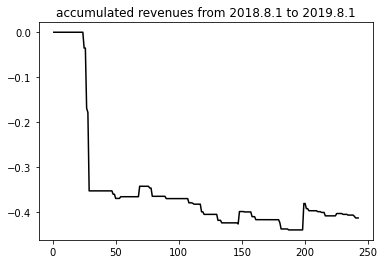

In [84]:
#累计收益图
plt.plot(x,y1,color = 'k')
plt.title('accumulated revenues from 2018.8.1 to 2019.8.1')
plt.show()

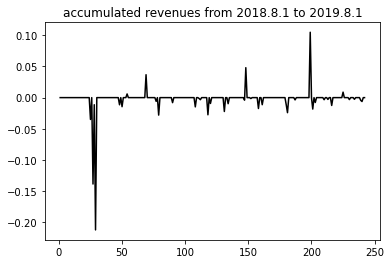

In [85]:
#基准收益图
plt.plot(x,y2,color = 'k')
plt.title('accumulated revenues from 2018.8.1 to 2019.8.1')
plt.show()

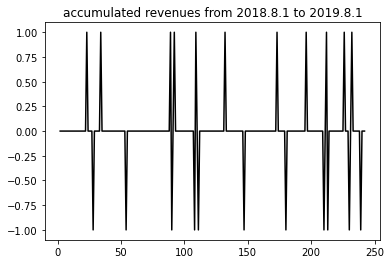

In [86]:
#交易信号图
#1  全仓买进    -1  全仓卖出
x = list(df_ldkg.index)
plt.plot(x,y3,color = 'k')
plt.title('accumulated revenues from 2018.8.1 to 2019.8.1')
plt.show()